In [ ]:
import torch
from transformers import AutoProcessor, Qwen2_5_VLForConditionalGeneration

device = "cuda"
model_name = "Qwen/Qwen2.5-VL-3B-Instruct"  # or 7B, 로컬 경로 등
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_name, torch_dtype=torch.bfloat16, device_map=None
).to(device).eval()
processor = AutoProcessor.from_pretrained(model_name)

def get_hidden_size(m):
    # LLM 히든 차원 D
    if hasattr(m.config, "hidden_size"):
        return m.config.hidden_size
    if hasattr(m, "model") and hasattr(m.model.config, "hidden_size"):
        return m.model.config.hidden_size
    # 최후 수단: 임베딩 차원 추정
    return m.model.embed_tokens.embedding_dim

def get_vision_and_projector(m):
    # 비전 타워 찾기
    vt = getattr(m, "vision_tower", None) or getattr(m, "visual", None) \
         or getattr(getattr(m, "model", m), "vision_tower", None) \
         or getattr(getattr(m, "model", m), "visual", None)
    # 프로젝터 찾기
    proj = getattr(m, "multi_modal_projector", None) or getattr(m, "mm_projector", None) \
           or getattr(getattr(m, "model", m), "multi_modal_projector", None) \
           or getattr(getattr(m, "model", m), "mm_projector", None)
    if vt is None or proj is None:
        raise RuntimeError("vision tower or multi-modal projector not found")
    return vt, proj

D = get_hidden_size(model)  # ← 이게 action expert의 image_feature_dim / text_guidance_dim과 일치해야 함
print("LLM hidden size (D):", D)

# 샘플 입력
texts = ["Describe the scene briefly."]  # 실제론 instruction을 그대로 사용
images = ["/home/najo/NAS/VLA/dataset/New_dataset2/Green_point/data_collection_20251108_053719/View1/ZED_41182735_left_1762547839.751.jpg"]       # 실제 이미지

inputs = processor(text=texts, images=images, return_tensors="pt").to(device)
with torch.no_grad():
    # 1) 비전 토큰 직접 추출 경로 (권장: projector 출력까지 뽑기)
    vt, proj = get_vision_and_projector(model)
    # 일부 구현은 vt가 래퍼일 수 있음. 통상 vt(images) → patch features (B, S_v, C_v)
    # processor가 만들어준 이미지 텐서를 재사용
    pixel_values = inputs.pop("pixel_values")  # (B, 3, H, W)
    vision_feats = vt(pixel_values)            # 모듈에 따라 (last_hidden_state) 등 객체일 수 있음
    if isinstance(vision_feats, (tuple, list)):
        vision_feats = vision_feats[0]
    if hasattr(vision_feats, "last_hidden_state"):
        vision_feats = vision_feats.last_hidden_state  # (B, S_v, C_v)

    context_features = proj(vision_feats)      # (B, S, D)로 투영됨
    # 이제 context_features가 곧 액션 디코더의 memory

    # 2) 텍스트 가이던스: LLM 히든에서 텍스트 토큰만 모아 평균
    outputs = model(**inputs, output_hidden_states=True, use_cache=False)
    # decoder-only라면 last_hidden_state가 (B, T, D)
    hs = outputs.hidden_states[-1]             # (B, T, D)

    input_ids = inputs["input_ids"]            # (B, T)
    # 이미지 플레이스홀더 토큰 ID를 프로세서에서 제공하는 경우가 있음
    image_token_id = getattr(processor.tokenizer, "image_token_id", None)
    # 텍스트 토큰 마스크 구성
    if image_token_id is not None:
        text_mask = (input_ids != image_token_id)
    else:
        # 일반적으로 special token 집합을 제외하고 선택 (필요시 커스터마이즈)
        special_ids = set(processor.tokenizer.all_special_ids)
        text_mask = torch.ones_like(input_ids, dtype=torch.bool)
        for sid in special_ids:
            text_mask &= (input_ids != sid)

    # 평균 풀링으로 guidance_vector 만들기
    # (이미지 자리표시자/스페셜 토큰 제외)
    mask = text_mask.float().unsqueeze(-1)     # (B, T, 1)
    denom = mask.sum(dim=1).clamp_min(1.0)     # (B, 1)
    guidance_vector = (hs * mask).sum(dim=1) / denom  # (B, D)

print("context_features:", tuple(context_features.shape))  # (B, S, D)
print("guidance_vector:", tuple(guidance_vector.shape))    # (B, D)


In [1]:
"""
Trajectory Visualization from Delta Actions

Reconstructs and visualizes the complete trajectory from delta actions
loaded by new_format_dataset.py. Shows both 3D position path and orientation changes.
(Plot only / No file saving)
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation  # 현재는 사용 안 하지만, 향후 확장용으로 유지
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (3D plot 활성화를 위한 import)
from scipy.spatial.transform import Rotation
from pathlib import Path
import sys

# Add parent directory to path
PROJECT_ROOT = Path(__file__).parent
sys.path.insert(0, str(PROJECT_ROOT))

from vla_datasets.unified_dataset import UnifiedVLADataset


def reconstruct_trajectory_from_deltas(initial_pose, delta_actions):
    """
    Reconstruct full trajectory from initial pose and delta actions.

    Args:
        initial_pose: [x, y, z, rx, ry, rz] initial pose in degrees
        delta_actions: [N, 7] array of delta actions
                       [dx, dy, dz, rot_vec_x, rot_vec_y, rot_vec_z, gripper]

    Returns:
        positions: [N+1, 3] array of positions
        orientations: [N+1, 3] array of euler angles in degrees
        gripper_states: [N] array of gripper states
    """
    num_steps = len(delta_actions)
    positions = np.zeros((num_steps + 1, 3))
    orientations = np.zeros((num_steps + 1, 3))
    gripper_states = delta_actions[:, 6]

    # Set initial state
    positions[0] = initial_pose[:3]
    orientations[0] = initial_pose[3:]

    # Current rotation
    current_rotation = Rotation.from_euler('xyz', initial_pose[3:], degrees=True)

    # Apply each delta action
    for i in range(num_steps):
        delta_action = delta_actions[i]

        # Translation delta
        delta_trans = delta_action[:3]
        positions[i + 1] = positions[i] + delta_trans

        # Rotation delta (rotation vector)
        delta_rot_vec = delta_action[3:6]
        delta_rotation = Rotation.from_rotvec(delta_rot_vec)

        # Apply rotation
        current_rotation = delta_rotation * current_rotation
        orientations[i + 1] = current_rotation.as_euler('xyz', degrees=True)

    return positions, orientations, gripper_states


def plot_trajectory_3d(positions, orientations, gripper_states, title="Robot Trajectory"):
    """
    Plot 3D trajectory with orientation arrows and gripper state colors.

    Args:
        positions: [N, 3] positions
        orientations: [N, 3] euler angles in degrees
        gripper_states: [N-1] or [N] gripper states (색상용)
        title: plot title
    """
    fig = plt.figure(figsize=(15, 5))

    # 3D trajectory plot
    ax1 = fig.add_subplot(131, projection='3d')

    # Color by gripper state
    colors = plt.cm.RdYlGn(gripper_states)

    # Trajectory line
    ax1.plot(
        positions[:, 0], positions[:, 1], positions[:, 2],
        'b-', alpha=0.3, linewidth=1
    )

    # Points colored by gripper state
    for i in range(len(positions) - 1):
        ax1.scatter(
            positions[i, 0], positions[i, 1], positions[i, 2],
            c=[colors[i]], s=20, alpha=0.6
        )

    # Mark start and end
    ax1.scatter(
        positions[0, 0], positions[0, 1], positions[0, 2],
        c='green', s=200, marker='o', label='Start',
        edgecolors='black', linewidths=2
    )
    ax1.scatter(
        positions[-1, 0], positions[-1, 1], positions[-1, 2],
        c='red', s=200, marker='*', label='End',
        edgecolors='black', linewidths=2
    )

    # Orientation arrows at key points
    arrow_step = max(1, len(positions) // 10)
    for i in range(0, len(positions), arrow_step):
        rot = Rotation.from_euler('xyz', orientations[i], degrees=True)
        direction = rot.apply([0, 0, 0.01])  # Small arrow in tool direction
        ax1.quiver(
            positions[i, 0], positions[i, 1], positions[i, 2],
            direction[0], direction[1], direction[2],
            color='black', alpha=0.5, arrow_length_ratio=0.3
        )

    ax1.set_xlabel('X (mm)')
    ax1.set_ylabel('Y (mm)')
    ax1.set_zlabel('Z (mm)')
    ax1.set_title('3D Trajectory')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # XY plane view (top view)
    ax2 = fig.add_subplot(132)
    ax2.plot(positions[:, 0], positions[:, 1], 'b-', alpha=0.3, linewidth=1)
    for i in range(len(positions) - 1):
        ax2.scatter(
            positions[i, 0], positions[i, 1],
            c=[colors[i]], s=20, alpha=0.6
        )
    ax2.scatter(
        positions[0, 0], positions[0, 1],
        c='green', s=200, marker='o',
        edgecolors='black', linewidths=2
    )
    ax2.scatter(
        positions[-1, 0], positions[-1, 1],
        c='red', s=200, marker='*',
        edgecolors='black', linewidths=2
    )
    ax2.set_xlabel('X (mm)')
    ax2.set_ylabel('Y (mm)')
    ax2.set_title('Top View (XY Plane)')
    ax2.grid(True, alpha=0.3)
    ax2.axis('equal')

    # XZ plane view (side view)
    ax3 = fig.add_subplot(133)
    ax3.plot(positions[:, 0], positions[:, 2], 'b-', alpha=0.3, linewidth=1)
    for i in range(len(positions) - 1):
        ax3.scatter(
            positions[i, 0], positions[i, 2],
            c=[colors[i]], s=20, alpha=0.6
        )
    ax3.scatter(
        positions[0, 0], positions[0, 2],
        c='green', s=200, marker='o',
        edgecolors='black', linewidths=2
    )
    ax3.scatter(
        positions[-1, 0], positions[-1, 2],
        c='red', s=200, marker='*',
        edgecolors='black', linewidths=2
    )
    ax3.set_xlabel('X (mm)')
    ax3.set_ylabel('Z (mm)')
    ax3.set_title('Side View (XZ Plane)')
    ax3.grid(True, alpha=0.3)

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()

    return fig


def plot_trajectory_details(positions, orientations, gripper_states):
    """
    Plot detailed trajectory information over time.
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    time_steps = np.arange(len(positions))

    # Position X over time
    ax = axes[0, 0]
    ax.plot(time_steps, positions[:, 0], 'r-', linewidth=2, alpha=0.7)
    ax.scatter(
        0, positions[0, 0],
        c='green', s=100, marker='o',
        edgecolors='black', linewidths=2, zorder=5
    )
    ax.scatter(
        len(positions) - 1, positions[-1, 0],
        c='red', s=100, marker='*',
        edgecolors='black', linewidths=2, zorder=5
    )
    ax.set_xlabel('Time Step')
    ax.set_ylabel('X Position (mm)')
    ax.set_title('X Position Over Time')
    ax.grid(True, alpha=0.3)

    # Position Y over time
    ax = axes[0, 1]
    ax.plot(time_steps, positions[:, 1], 'g-', linewidth=2, alpha=0.7)
    ax.scatter(
        0, positions[0, 1],
        c='green', s=100, marker='o',
        edgecolors='black', linewidths=2, zorder=5
    )
    ax.scatter(
        len(positions) - 1, positions[-1, 1],
        c='red', s=100, marker='*',
        edgecolors='black', linewidths=2, zorder=5
    )
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Y Position (mm)')
    ax.set_title('Y Position Over Time')
    ax.grid(True, alpha=0.3)

    # Position Z over time
    ax = axes[0, 2]
    ax.plot(time_steps, positions[:, 2], 'b-', linewidth=2, alpha=0.7)
    ax.scatter(
        0, positions[0, 2],
        c='green', s=100, marker='o',
        edgecolors='black', linewidths=2, zorder=5
    )
    ax.scatter(
        len(positions) - 1, positions[-1, 2],
        c='red', s=100, marker='*',
        edgecolors='black', linewidths=2, zorder=5
    )
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Z Position (mm)')
    ax.set_title('Z Position Over Time')
    ax.grid(True, alpha=0.3)

    # Orientation RX over time
    ax = axes[1, 0]
    ax.plot(time_steps, orientations[:, 0], 'r-', linewidth=2, alpha=0.7)
    ax.scatter(
        0, orientations[0, 0],
        c='green', s=100, marker='o',
        edgecolors='black', linewidths=2, zorder=5
    )
    ax.scatter(
        len(orientations) - 1, orientations[-1, 0],
        c='red', s=100, marker='*',
        edgecolors='black', linewidths=2, zorder=5
    )
    ax.set_xlabel('Time Step')
    ax.set_ylabel('RX Orientation (degrees)')
    ax.set_title('RX Orientation Over Time')
    ax.grid(True, alpha=0.3)

    # Orientation RY over time
    ax = axes[1, 1]
    ax.plot(time_steps, orientations[:, 1], 'g-', linewidth=2, alpha=0.7)
    ax.scatter(
        0, orientations[0, 1],
        c='green', s=100, marker='o',
        edgecolors='black', linewidths=2, zorder=5
    )
    ax.scatter(
        len(orientations) - 1, orientations[-1, 1],
        c='red', s=100, marker='*',
        edgecolors='black', linewidths=2, zorder=5
    )
    ax.set_xlabel('Time Step')
    ax.set_ylabel('RY Orientation (degrees)')
    ax.set_title('RY Orientation Over Time')
    ax.grid(True, alpha=0.3)

    # Orientation RZ over time
    ax = axes[1, 2]
    ax.plot(time_steps, orientations[:, 2], 'b-', linewidth=2, alpha=0.7)
    ax.scatter(
        0, orientations[0, 2],
        c='green', s=100, marker='o',
        edgecolors='black', linewidths=2, zorder=5
    )
    ax.scatter(
        len(orientations) - 1, orientations[-1, 2],
        c='red', s=100, marker='*',
        edgecolors='black', linewidths=2, zorder=5
    )
    ax.set_xlabel('Time Step')
    ax.set_ylabel('RZ Orientation (degrees)')
    ax.set_title('RZ Orientation Over Time')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig


def visualize_episode_trajectory(episode_path, sample_idx=0, full_episode=False):
    """
    Visualize trajectory for a specific episode.

    Args:
        episode_path: Path to episode directory
        sample_idx: Which sample index to visualize (ignored if full_episode=True)
        full_episode: If True, visualize entire episode instead of single sample
    """
    episode_path = Path(episode_path)

    print(f"Loading episode: {episode_path.name}")
    if not full_episode:
        print(f"Sample index: {sample_idx}")
    else:
        print(f"Mode: Full episode")

    # Load dataset
    ds = UnifiedVLADataset(
        data_dir=str(episode_path),
        format='new',
        horizon=8,
        vlm_reuse_count=3,
        sensor_window_size=650,
        robot_window_size=100,
        action_expert_hz=10,
        use_cache=False,
    )

    if len(ds) == 0:
        print("❌ Dataset is empty!")
        return

    print(f"\nDataset info:")
    print(f"  Total samples: {len(ds)}")
    print(f"  Horizon: {ds.horizon}")
    print(f"  Action interval: {ds.action_interval}")
    print(f"  Number of actions: {ds.num_actions}")
    print(f"  Total poses: {len(ds.poses)}")

    if full_episode:
        # Use all poses from the episode
        positions = ds.poses[:, :3]
        orientations = ds.poses[:, 3:]

        # Dummy gripper states (all open)
        gripper_states = np.ones(len(positions) - 1)

        print(f"\nFull episode trajectory:")
        print(f"  Total steps: {len(positions)}")
        print(
            f"  Start position: "
            f"[{positions[0, 0]:.2f}, {positions[0, 1]:.2f}, {positions[0, 2]:.2f}] mm"
        )
        print(
            f"  End position: "
            f"[{positions[-1, 0]:.2f}, {positions[-1, 1]:.2f}, {positions[-1, 2]:.2f}] mm"
        )
        print(f"  Total displacement: {np.linalg.norm(positions[-1] - positions[0]):.2f} mm")

        step_sizes = np.linalg.norm(np.diff(positions, axis=0), axis=1)
        print(f"  Max step size: {np.max(step_sizes):.2f} mm")
        print(f"  Min step size: {np.min(step_sizes):.4f} mm")
        print(f"  Mean step size: {np.mean(step_sizes):.4f} mm")

        title_suffix = "Full Episode"
    else:
        # Single sample visualization
        if sample_idx >= len(ds):
            print(f"⚠️ Sample index {sample_idx} out of range. Using 0 instead.")
            sample_idx = 0

        sample = ds[sample_idx]
        delta_actions = sample['actions'].numpy()

        print(f"\nSample {sample_idx} info:")
        print(f"  Delta actions shape: {delta_actions.shape}")
        print(f"  VLM idx: {sample['vlm_idx']}")
        print(f"  Episode: {sample['episode_id']}")

        # Initial pose
        action_step_idx = sample_idx * ds.action_interval
        initial_pose = ds.poses[action_step_idx]

        print(f"\nInitial pose at step {action_step_idx}:")
        print(
            f"  Position: "
            f"[{initial_pose[0]:.2f}, {initial_pose[1]:.2f}, {initial_pose[2]:.2f}] mm"
        )
        print(
            f"  Orientation: "
            f"[{initial_pose[3]:.2f}, {initial_pose[4]:.2f}, {initial_pose[5]:.2f}] deg"
        )

        # Reconstruct trajectory
        positions, orientations, gripper_states = reconstruct_trajectory_from_deltas(
            initial_pose, delta_actions
        )

        print(f"\nReconstructed trajectory:")
        print(f"  Start position: {positions[0]}")
        print(f"  End position: {positions[-1]}")
        print(f"  Total displacement: {np.linalg.norm(positions[-1] - positions[0]):.2f} mm")
        print(
            f"  Max step size: "
            f"{np.max(np.linalg.norm(np.diff(positions, axis=0), axis=1)):.2f} mm"
        )
        print(
            f"  Min step size: "
            f"{np.min(np.linalg.norm(np.diff(positions, axis=0), axis=1)):.4f} mm"
        )

        title_suffix = f"Sample {sample_idx}"

    # Create visualizations
    task_name = episode_path.parent.name
    title = f"{task_name} - {episode_path.name} ({title_suffix})"

    _ = plot_trajectory_3d(positions, orientations, gripper_states, title)
    _ = plot_trajectory_details(positions, orientations, gripper_states)

    plt.show()


def compare_multiple_episodes(episode_paths, sample_idx=0):
    """
    Compare trajectories from multiple episodes side by side.
    (Plot only / No file saving)
    """
    fig = plt.figure(figsize=(5 * len(episode_paths), 5))

    for i, episode_path in enumerate(episode_paths):
        episode_path = Path(episode_path)

        ds = UnifiedVLADataset(
            data_dir=str(episode_path),
            format='new',
            horizon=8,
            vlm_reuse_count=3,
            sensor_window_size=650,
            robot_window_size=100,
            action_expert_hz=10,
            use_cache=False,
        )

        if len(ds) == 0:
            print(f"⚠️ Episode {episode_path} dataset is empty, skipping.")
            continue

        sample = ds[min(sample_idx, len(ds) - 1)]
        delta_actions = sample['actions'].numpy()

        action_step_idx = min(sample_idx, len(ds) - 1) * ds.action_interval
        initial_pose = ds.poses[action_step_idx]

        positions, orientations, gripper_states = reconstruct_trajectory_from_deltas(
            initial_pose, delta_actions
        )

        ax = fig.add_subplot(1, len(episode_paths), i + 1, projection='3d')

        colors = plt.cm.RdYlGn(gripper_states)
        ax.plot(
            positions[:, 0], positions[:, 1], positions[:, 2],
            'b-', alpha=0.3, linewidth=1
        )

        for j in range(len(positions) - 1):
            ax.scatter(
                positions[j, 0], positions[j, 1], positions[j, 2],
                c=[colors[j]], s=20, alpha=0.6
            )

        ax.scatter(
            positions[0, 0], positions[0, 1], positions[0, 2],
            c='green', s=200, marker='o',
            edgecolors='black', linewidths=2
        )
        ax.scatter(
            positions[-1, 0], positions[-1, 1], positions[-1, 2],
            c='red', s=200, marker='*',
            edgecolors='black', linewidths=2
        )

        ax.set_xlabel('X (mm)')
        ax.set_ylabel('Y (mm)')
        ax.set_zlabel('Z (mm)')
        ax.set_title(f"{episode_path.parent.name}\n{episode_path.name}")
        ax.grid(True, alpha=0.3)

    plt.suptitle(f"Trajectory Comparison (Sample {sample_idx})", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser(
        description="Visualize robot trajectory from delta actions (plot only)"
    )
    parser.add_argument("episode_path", type=str, help="Path to episode directory")
    parser.add_argument("--sample_idx", type=int, default=0, help="Sample index to visualize")
    parser.add_argument(
        "--full_episode",
        action="store_true",
        help="Visualize the full episode trajectory instead of a single sample",
    )
    parser.add_argument(
        "--compare",
        nargs="+",
        help="Additional episode paths to compare with the main one",
    )

    args = parser.parse_args()

    if args.compare:
        # Compare multiple episodes
        all_episodes = [args.episode_path] + args.compare
        compare_multiple_episodes(all_episodes, args.sample_idx)
    else:
        # Visualize single episode (sample or full)
        visualize_episode_trajectory(
            args.episode_path,
            sample_idx=args.sample_idx,
            full_episode=args.full_episode,
        )


NameError: name '__file__' is not defined

Dataset loaded from: /home/najo/NAS/VLA/dataset/New_dataset3/Red_point/data_collection_20251110_065813
  Total samples        : 373
  Horizon              : 8
  Action interval      : 10
  Num poses (robot log): 3740

Episode trajectory stats:
  Total steps      : 3740
  Start position   : [184.75238   -8.981626 283.03088 ]
  End position     : [169.05537  -22.135391 216.59775 ]
  Total displacement (L2): 69.518
  Max step size    : 0.0855
  Min step size    : 0.0000
  Mean step size   : 0.0193


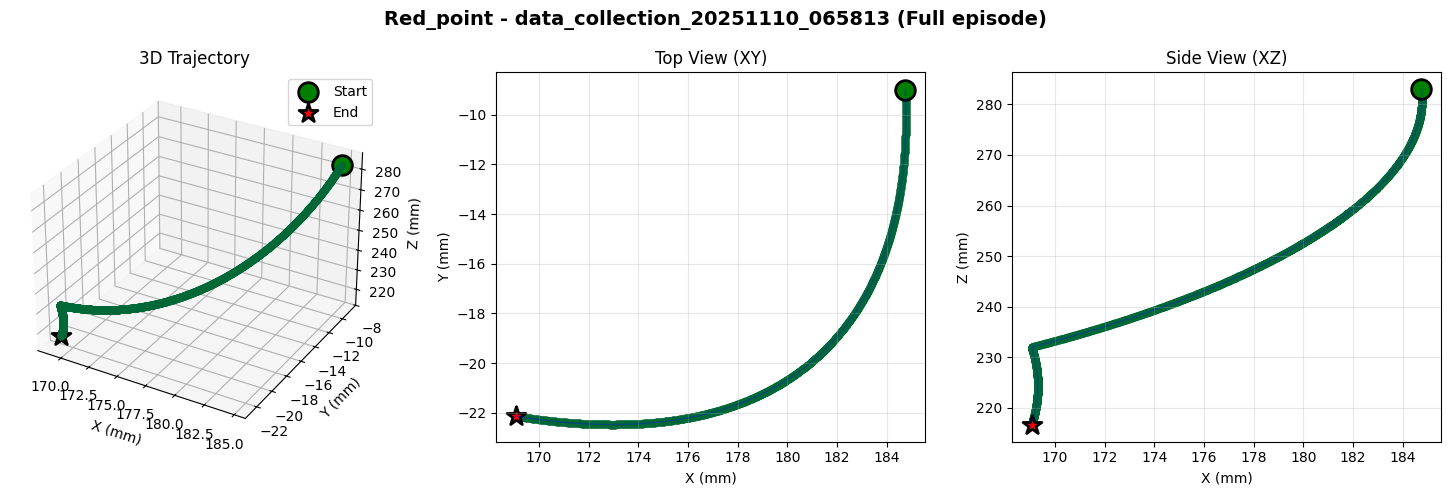

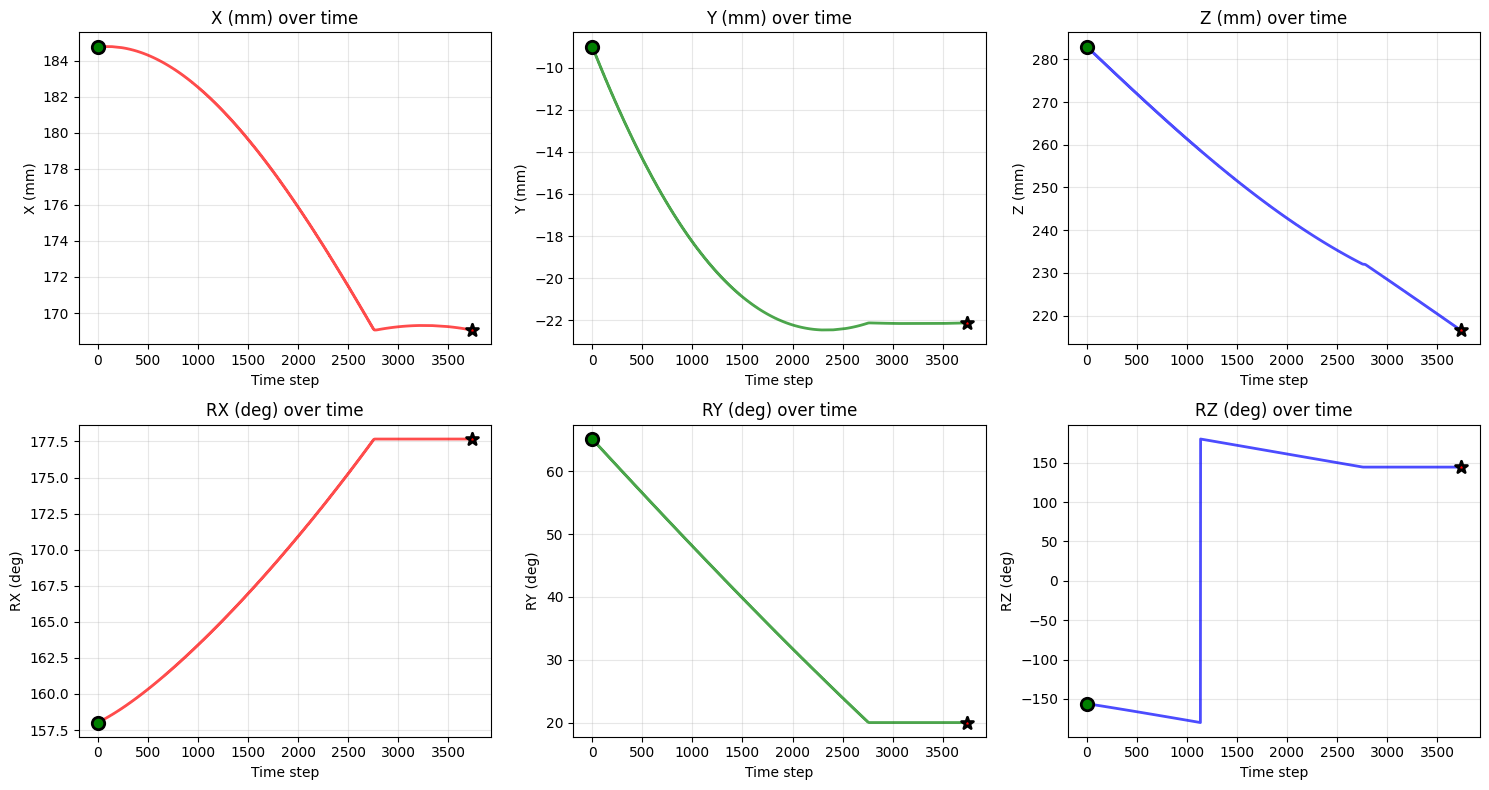

In [2]:
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

# ---------------------------------------------------------------------
# 0. 프로젝트 루트 & 모듈 경로 설정 (필요 시 수정)
# ---------------------------------------------------------------------
# 예: Notebook이 Insertion_VLAv3 폴더 안에서 실행 중이면 그대로 둬도 됨
PROJECT_ROOT = Path.cwd()  # 필요하면 Path("/home/najo/NAS/VLA/Insertion_VLAv3") 같이 명시해도 됨
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from vla_datasets.unified_dataset import UnifiedVLADataset

# ---------------------------------------------------------------------
# 1. 플로팅 함수 정의
# ---------------------------------------------------------------------
def plot_trajectory_3d(positions, orientations, gripper_states=None, title="Robot Trajectory"):
    """
    3D 궤적 + XY, XZ 평면 시각화
    positions: [T, 3]
    orientations: [T, 3] (deg, xyz euler)
    gripper_states: [T-1] or [T], 색상용 (없으면 전부 동일 색으로 처리)
    """
    if gripper_states is None:
        gripper_states = np.ones(len(positions) - 1)
    colors = plt.cm.RdYlGn(gripper_states)

    fig = plt.figure(figsize=(15, 5))

    # 3D trajectory
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot(positions[:, 0], positions[:, 1], positions[:, 2],
             'b-', alpha=0.3, linewidth=1)

    for i in range(len(positions) - 1):
        ax1.scatter(positions[i, 0], positions[i, 1], positions[i, 2],
                    c=[colors[i]], s=20, alpha=0.6)

    ax1.scatter(positions[0, 0], positions[0, 1], positions[0, 2],
                c='green', s=200, marker='o', label='Start',
                edgecolors='black', linewidths=2)
    ax1.scatter(positions[-1, 0], positions[-1, 1], positions[-1, 2],
                c='red', s=200, marker='*', label='End',
                edgecolors='black', linewidths=2)

    # Orientation arrows (간격 줄여서)
    arrow_step = max(1, len(positions) // 15)
    for i in range(0, len(positions), arrow_step):
        rot = Rotation.from_euler('xyz', orientations[i], degrees=True)
        direction = rot.apply([0, 0, 0.01])
        ax1.quiver(positions[i, 0], positions[i, 1], positions[i, 2],
                   direction[0], direction[1], direction[2],
                   color='black', alpha=0.5, arrow_length_ratio=0.3)

    ax1.set_xlabel('X (mm)')
    ax1.set_ylabel('Y (mm)')
    ax1.set_zlabel('Z (mm)')
    ax1.set_title('3D Trajectory')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # XY plane
    ax2 = fig.add_subplot(132)
    ax2.plot(positions[:, 0], positions[:, 1], 'b-', alpha=0.3, linewidth=1)
    for i in range(len(positions) - 1):
        ax2.scatter(positions[i, 0], positions[i, 1],
                    c=[colors[i]], s=20, alpha=0.6)
    ax2.scatter(positions[0, 0], positions[0, 1],
                c='green', s=200, marker='o',
                edgecolors='black', linewidths=2)
    ax2.scatter(positions[-1, 0], positions[-1, 1],
                c='red', s=200, marker='*',
                edgecolors='black', linewidths=2)
    ax2.set_xlabel('X (mm)')
    ax2.set_ylabel('Y (mm)')
    ax2.set_title('Top View (XY)')
    ax2.grid(True, alpha=0.3)
    ax2.axis('equal')

    # XZ plane
    ax3 = fig.add_subplot(133)
    ax3.plot(positions[:, 0], positions[:, 2], 'b-', alpha=0.3, linewidth=1)
    for i in range(len(positions) - 1):
        ax3.scatter(positions[i, 0], positions[i, 2],
                    c=[colors[i]], s=20, alpha=0.6)
    ax3.scatter(positions[0, 0], positions[0, 2],
                c='green', s=200, marker='o',
                edgecolors='black', linewidths=2)
    ax3.scatter(positions[-1, 0], positions[-1, 2],
                c='red', s=200, marker='*',
                edgecolors='black', linewidths=2)
    ax3.set_xlabel('X (mm)')
    ax3.set_ylabel('Z (mm)')
    ax3.set_title('Side View (XZ)')
    ax3.grid(True, alpha=0.3)

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig


def plot_trajectory_details(positions, orientations):
    """
    시간에 따른 X/Y/Z, RX/RY/RZ 변화를 플롯
    """
    T = len(positions)
    t = np.arange(T)

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    # X, Y, Z
    labels_pos = ['X (mm)', 'Y (mm)', 'Z (mm)']
    colors_pos = ['r', 'g', 'b']
    for i in range(3):
        ax = axes[0, i]
        ax.plot(t, positions[:, i], colors_pos[i] + '-', linewidth=2, alpha=0.7)
        ax.scatter(0, positions[0, i],
                   c='green', s=80, marker='o',
                   edgecolors='black', linewidths=2, zorder=5)
        ax.scatter(T-1, positions[-1, i],
                   c='red', s=80, marker='*',
                   edgecolors='black', linewidths=2, zorder=5)
        ax.set_xlabel('Time step')
        ax.set_ylabel(labels_pos[i])
        ax.set_title(f'{labels_pos[i]} over time')
        ax.grid(True, alpha=0.3)

    # RX, RY, RZ
    labels_rot = ['RX (deg)', 'RY (deg)', 'RZ (deg)']
    colors_rot = ['r', 'g', 'b']
    for i in range(3):
        ax = axes[1, i]
        ax.plot(t, orientations[:, i], colors_rot[i] + '-', linewidth=2, alpha=0.7)
        ax.scatter(0, orientations[0, i],
                   c='green', s=80, marker='o',
                   edgecolors='black', linewidths=2, zorder=5)
        ax.scatter(T-1, orientations[-1, i],
                   c='red', s=80, marker='*',
                   edgecolors='black', linewidths=2, zorder=5)
        ax.set_xlabel('Time step')
        ax.set_ylabel(labels_rot[i])
        ax.set_title(f'{labels_rot[i]} over time')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

# ---------------------------------------------------------------------
# 2. 에피소드 전체 로봇 궤적 시각화
# ---------------------------------------------------------------------
EPISODE_PATH = Path("/home/najo/NAS/VLA/dataset/New_dataset3/Red_point/data_collection_20251110_065813")

ds = UnifiedVLADataset(
    data_dir=str(EPISODE_PATH),
    format='new',
    horizon=8,
    vlm_reuse_count=3,
    sensor_window_size=650,
    robot_window_size=100,
    action_expert_hz=10,
    use_cache=False,
)

print(f"Dataset loaded from: {EPISODE_PATH}")
print(f"  Total samples        : {len(ds)}")
print(f"  Horizon              : {ds.horizon}")
print(f"  Action interval      : {ds.action_interval}")
print(f"  Num poses (robot log): {len(ds.poses)}")

# 로봇의 모든 동작 (전체 타임스텝) 사용
poses = ds.poses  # [T, 6] = [x, y, z, rx, ry, rz]
positions = poses[:, :3]
orientations = poses[:, 3:6]

# 색상용 gripper state가 없으므로 dummy로 채우기 (전부 동일)
gripper_states = np.ones(len(positions) - 1)

print("\nEpisode trajectory stats:")
print(f"  Total steps      : {len(positions)}")
print(f"  Start position   : {positions[0]}")
print(f"  End position     : {positions[-1]}")
print(f"  Total displacement (L2): {np.linalg.norm(positions[-1] - positions[0]):.3f}")

step_sizes = np.linalg.norm(np.diff(positions, axis=0), axis=1)
print(f"  Max step size    : {np.max(step_sizes):.4f}")
print(f"  Min step size    : {np.min(step_sizes):.4f}")
print(f"  Mean step size   : {np.mean(step_sizes):.4f}")

# 플로팅
_ = plot_trajectory_3d(positions, orientations, gripper_states,
                       title=f"{EPISODE_PATH.parent.name} - {EPISODE_PATH.name} (Full episode)")
_ = plot_trajectory_details(positions, orientations)

plt.show()


In [2]:
from PIL import Image
import glob
import os
import natsort # 자연어 정렬

# 1. 이미지가 있는 폴더 경로
image_folder = '/home/najo/NAS/VLA/dataset/New_dataset3/Red_point/data_collection_20251110_070949/View4'  # <--- 이 경로를 수정하세요.
gif_path = 'View4.gif'

# 2. 파일 목록 가져오기
file_list = glob.glob(os.path.join(image_folder, '*.jpg'))

# 3. 파일 목록 정렬
sorted_files = natsort.natsorted(file_list)

if not sorted_files:
    print(f"'{image_folder}' 폴더에서 이미지를 찾을 수 없습니다.")
else:
    # 4. 이미지 파일들을 PIL Image 객체로 열기
    images = [Image.open(fp) for fp in sorted_files]
    
    # 5. 첫 번째 이미지를 기준으로 GIF 저장
    first_image = images[0]
    
    # duration: 각 프레임이 표시되는 시간 (밀리초 단위). 100ms = 0.1초
    # loop: 0은 무한 반복
    first_image.save(
        gif_path,
        save_all=True,
        append_images=images[1:],  # 두 번째 이미지부터 프레임으로 추가
        duration=10,
        loop=0
    )

    print(f"'{gif_path}'에 GIF가 성공적으로 저장되었습니다.")

'View4.gif'에 GIF가 성공적으로 저장되었습니다.


In [2]:
import imageio.v3 as iio  # imageio를 가져옵니다
import glob
import os
import natsort

# 1. 경로 설정
image_folder = '/home/najo/NAS/VLA/dataset/New_dataset3/Red_point/data_collection_20251110_070949/View4'  # <--- 이 경로를 수정하세요.
gif_path = 'View4.gif'

# 2. 파일 목록 가져오기 및 정렬
file_list = glob.glob(os.path.join(image_folder, '*.jpg'))
sorted_files = natsort.natsorted(file_list)

if not sorted_files:
    print(f"'{image_folder}' 폴더에서 이미지를 찾을 수 없습니다.")
else:
    # 3. imageio로 이미지 읽기
    # images = [Image.open(fp) for fp in sorted_files] -> 이 부분을 변경
    images = [iio.imread(fp) for fp in sorted_files]

    # 4. imageio로 GIF 저장 (훨씬 간단함)
    # duration은 초 단위로 바뀌었을 수 있으니, 밀리초 단위로 지정하려면 
    # imageio v3에서는 duration을 밀리초 단위로 씁니다. (100ms = 0.1초)
    iio.imwrite(
        gif_path,
        images,
        duration=10,  # 각 이미지의 표시 시간 (ms)
        loop=0         # 0 = 무한 반복
    )

    print(f"'{gif_path}'에 고품질 GIF가 성공적으로 저장되었습니다.")
    

'View4.gif'에 고품질 GIF가 성공적으로 저장되었습니다.
